# The impact of parameters on the performance of random forests

[La Permanence](https://www.la-permanence.com) offers coworking space at two locations in Paris (*rue du Fer à Moulin* and *rue d'Alésia*).  

One of our goals in this repository is to forecast the number of available seats, say over the next two weeks, and random forests are one such technique.

In this notebook we investigate the impact of the parameters on the performance of the model.  There are many parameters in [`sklearn.RandomForestRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) that can be adjusted in order to improve the predictions and we will focus on the following.  
-  The number of trees: `n_estimators`; the default value is (currently) **10**.   
-  The minimum number of samples required to be at a leaf node: `min_leaves_sample`; the default value is **1**.  
-  The maximum number of features to consider when looking for the best split: `max_features`; the default is to use **all** features.  



## Metrics used to assess model performance

We will use the root mean squared error (RMSE) and $R^2$ score to assess the predictions.  If various models are applied to the same dataset, then RMSE and $R^2$ provide the same qualitative information, in the sense that optimal choices of the model's parameters are the same whether the metric used is RMSE or $R^2$.  



## The fastai library
The code in this notebook follows closely lessons 1 through 4 of fastai's [Introduction to Machine Learning for Coders](http://course18.fast.ai/ml) course.  The corresponding notebooks from the course's github repository are [lesson1-rf.ipynb and lesson2-rf-interpretation.ipynb](https://github.com/fastai/fastai/tree/master/courses/ml1).  This notebook uses [version 0.7](https://github.com/fastai/fastai/tree/master/old/fastai) of the fastai library.

## Imports

In [1]:
import os
import sys
import re
# import tqdm  # class tqdm.tqdm imported from fastai.structured - see below

import pytz
import datetime

import math
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from scipy.cluster import hierarchy as hc

# The fastai repository is cloned into ~/Computing on my computer
# Version 0.7 of the fastai library is in fastai/old in the repository
sys.path.append(os.path.join(os.path.expanduser("~"), "Computing/fastai/old"))
from fastai.structured import *

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

## Constants

In [2]:
# Timezones
tz_utc = pytz.timezone("UTC")  # timestamp is in UTC standard
tz_paris = pytz.timezone("Europe/Paris")  # locations are in Paris, France

# Resampling rule: resolution of time regularization
RESOL = 10
RULE = f"{RESOL}T"
TWO_WEEKS = 2*7*24*(60 // RESOL)  # validation period is two weeks

# Colors for plotting
COL_TRAIN = plt.rcParams['axes.prop_cycle'].by_key()['color'][2]
COL_VALID = plt.rcParams['axes.prop_cycle'].by_key()['color'][3]
COL_PREDICT = plt.rcParams['axes.prop_cycle'].by_key()['color'][4]

## Helper functions  

In [3]:
def split_vals(df, n):
    """Split data into training and validation sets."""
    return df[:n].copy(), df[n:].copy()
        
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

## Data
The dataset is saved in a `csv` file located in `~/Projects/la_permanence/attendance.csv`.  

**Note**: `attendance.csv` is a misnomer, as the file actually records the number of *available* seats, rather than the number of seats used.  

### Metadata on the dataset

In [4]:
filename = 'attendance.csv'
foldername = 'Projects/la_permanence'
filepath = os.path.join(os.path.expanduser("~"), foldername, filename)
filesize = os.path.getsize(filepath)

COL_WIDTH = 20  # for display in this cell

if filesize > 1e6:
    print("{0}{1:d}MB".format("File size:".ljust(COL_WIDTH), filesize//int(1e6)))
elif filesize > 1e3:
    print("{0}{1:d}KB".format("File size:".ljust(COL_WIDTH), filesize//int(1e3)))
else:
    print("{0}{1:d}B".format("File size:".ljust(COL_WIDTH), filesize))

line_number = !wc -l < {filepath}
line_number = int(line_number[0])
print("{0}{1}".format("Number of rows:".ljust(COL_WIDTH), line_number))
first_row = !head -1 {filepath}
column_names = first_row[0].split(',')
print("{0}{1}".format("Names of columns:".ljust(COL_WIDTH), ", ".join(column_names)))


File size:          1MB
Number of rows:     40930
Names of columns:   timestamp, Moulin, Alésia


### More details on the columns
-  `timestamp` gives the date and time (UTC) of data collection in the format "YYYY-MM-DD-hh-mm-ss" where
`YYYY=year`,
`MM=month`,
`DD=day`,
`hh=hour`,
`mm=minute`,
`ss=second`;  
-  `Moulin` gives the number of available seats at the rue du Fer à Moulin location (maximum is 63);
-  `Alésia` gives the number of available seats at the rue d'Alésia location (maximum is 82).  

### Load the data

In [5]:
# %%prun
%time
dateparse = lambda x: pd.datetime.strptime(x, '%Y-%m-%d-%H-%M-%S')

raw_data = pd.read_csv(
    filepath,
    sep=',',
    dtype={'Moulin': np.uint8, 'Alésia': np.uint8},
    parse_dates=['timestamp'],
    date_parser=dateparse
)

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 6.2 µs


### Adjusting for timezones

The `timestamp` values are in the UTC standard, while the coworking spaces are located in Paris, France:

In [6]:
%time
raw_data['timestamp'] = raw_data['timestamp'].apply(lambda ts: ts.tz_localize(tz_utc).tz_convert(tz_paris))

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.01 µs


### Time regularization

The data is collected at irregular times and thus we resample (at a resolution specified in `RULE`) and interpolate to regularize the data:

In [7]:
raw_data.set_index("timestamp", inplace=True)
raw_data = raw_data.resample(RULE).mean().interpolate().round().astype(np.uint8)
raw_data.reset_index('timestamp', inplace=True)

### Expanding date information

The next cell extracts particular date fields from a complete datetime for the purpose of constructing categoricals: `Year`, `Month`, `Week`, `Day`, `Dayofweek`, `Dayofyear`, `Is_month_end`, `Is_month_start`, `Is_quarter_end`, `Is_quarter_start`, `Is_year_end`, `Is_year_start`, `Hour`, `Minute`, `Second`.  Of course, not all of these will be useful or even relevant, and for the purpose of exploration we keep them all in the dataframe for the moment.  

In [8]:
timestamps = raw_data.loc[:, ['timestamp']]
add_datepart(raw_data, 'timestamp', time=True)

## Rue du Fer à Moulin
We first concentrate on the location on rue du Fer à Moulin.

### Separating dependent from independent variables  
The following could be done by hand, but the custom function `proc_df` can perform additional transformations which are useful in the general case.

In [50]:
df, y, nas = proc_df(raw_data.drop('Alésia', axis=1), 'Moulin')

### Splitting data into training and validation sets  

In [51]:
n_valid = TWO_WEEKS  
n_trn = raw_data.shape[0] - n_valid

X_train, X_valid = split_vals(df, n_trn)
y_train, y_valid = split_vals(y, n_trn)

# For plotting purposes:
timestamps_train = timestamps.iloc[0:n_trn].copy()
timestamps_valid = timestamps.iloc[n_trn:].copy()

### Random forests with default values

We first use random forests with default values.  

*Note.*  As of now, the default value for `n_estimators` in [`sklearn.RandomForestRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) is 10, although it will be changed to 100.  

In [11]:
m = RandomForestRegressor(n_jobs=-1, n_estimators=10)
%time m.fit(X_train, y_train)
COL_WIDTH = 20
print("{0}: {1}".format("RMSE (train)".ljust(COL_WIDTH), rmse(m.predict(X_train), y_train)))
print("{0}: {1}".format("RMSE (validation)".ljust(COL_WIDTH), rmse(m.predict(X_valid), y_valid)))
print("{0}: {1}".format("R2 (train)".ljust(COL_WIDTH), m.score(X_train, y_train)))
print("{0}: {1}".format("R2 (validation)".ljust(COL_WIDTH), m.score(X_valid, y_valid)))

y_predict = m.predict(X_valid)

CPU times: user 245 ms, sys: 6.66 ms, total: 252 ms
Wall time: 119 ms
RMSE (train)        : 0.7026421368199575
RMSE (validation)   : 8.371451510749221
R2 (train)          : 0.998336367936021
R2 (validation)     : 0.8132470707555377


The performance as measured on the training set, not suprisingly, is  very high, but those on the validation set are  nevertheless promising given that we are using default parameters.

### Visualizing the predictions

/anaconda3/envs/fastai-cpu/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


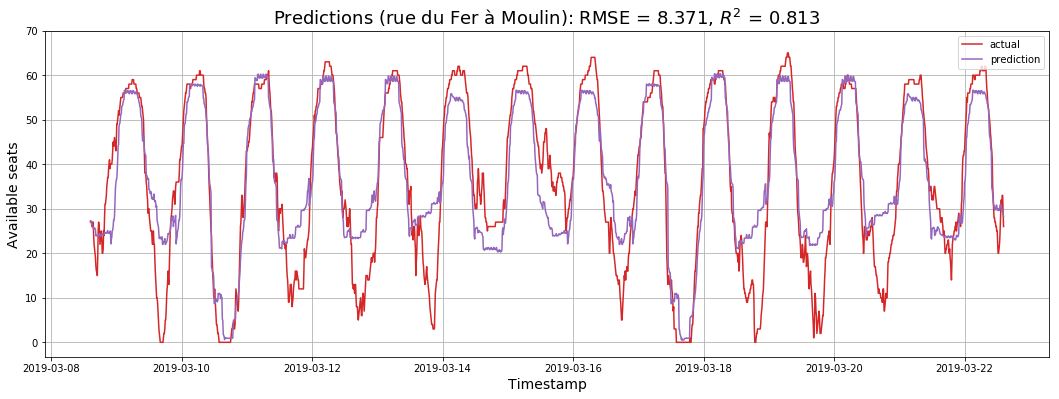

In [12]:
fig, ax = plt.subplots(figsize=(18, 6));
ax.plot(timestamps_valid['timestamp'], y_valid, COL_VALID);
ax.plot(timestamps_valid['timestamp'], y_predict, COL_PREDICT);
ax.set_title(
    "Predictions (rue du Fer à Moulin): RMSE = {0:.4g}, $R^2$ = {1:.3g}".format(
        rmse(m.predict(X_valid), y_valid),
        m.score(X_valid, y_valid)
    ),
    fontsize=18
)

ax.set_ylabel("Available seats", fontsize=14);
ax.set_yticks(range(0, 80, 10));
ax.set_xlabel("Timestamp", fontsize=14);
ax.legend(['actual', 'prediction'], loc='upper right')
ax.grid();

### First impressions
Depending on the run, the results may be unimpressive or very encouraging.  In any case, it should be clear that random forests are at least reasonably effective at picking up the general behavior of the seat availability, and where they do not perform so well is when the availability is particularly low or high.

One key observation is that increasing the number of trees will improve the stability of the results.  Before investigating the effect of taking a high value for `n_estimators`, we perform a grid search over a range of values for the other two parameters of interest, `min_samples_leaf` and `max_features`.

Thus for the moment we fix

In [13]:
nb_trees = 10

## A quick scan through the model parameters `min_samples_leaf` and `max_features`

We measure the RMSE and the $R^2$ score for a range of parameter values:

In [14]:
MIN_LEAVES = [2**i for i in range(10)]
MAX_FEATURES = range(1, len(df.columns)+1, 2)

performance_list = []

for i, j in tqdm([(x, y) for x in MIN_LEAVES for y in MAX_FEATURES]):
    m = RandomForestRegressor(n_jobs=-1, n_estimators=nb_trees, min_samples_leaf=i, max_features=j)
    m.fit(X_train, y_train)
    D = {
        'min leaves': i,
        'max features': j,
        'rmse': rmse(m.predict(X_valid), y_valid),
        'R2': m.score(X_valid, y_valid)
    }
    performance_list.append(D)

100%|██████████| 80/80 [00:27<00:00,  2.97it/s]


In [15]:
performance = pd.DataFrame(performance_list)[['min leaves', 'max features', 'rmse', 'R2']]

df_rmse = pd.pivot_table(performance, index='min leaves', columns='max features', values='rmse')
df_r2 = pd.pivot_table(performance, index='min leaves', columns='max features', values='R2')

Plot heatmaps for RMSE and $R^2$:

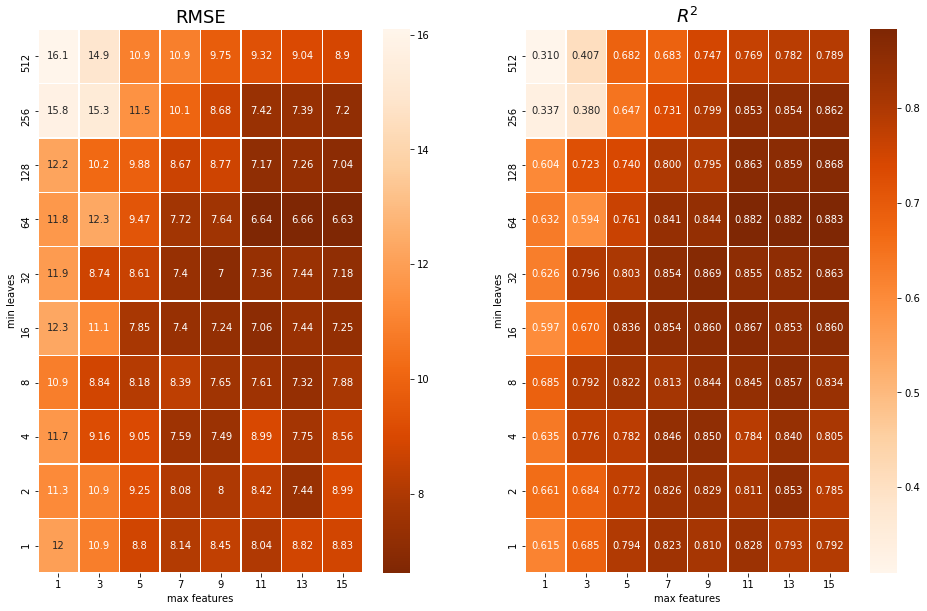

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 10));
plt.subplots_adjust(wspace=0.2);
sns.heatmap(df_rmse.sort_index(ascending=False), annot=True, cmap="Oranges_r", linewidths=.5, fmt='.3g', ax=ax1);
ax1.set_title("RMSE", fontsize=18);
sns.heatmap(df_r2.sort_index(ascending=False), annot=True, cmap="Oranges", linewidths=.5, fmt='.3f', ax=ax2);
ax2.set_title("$R^2$", fontsize=18);

**Remark on the color maps.**  The color maps are so chosen that in both cases *darker colors mean better results*.  However, since we do not wish to compare RMSE and $R^2$, colors for one metric are not meant to correspond to color for the other.  

**Observations.**  
The heatmaps show a decent level of regularity and thus we can reasonably conclude that they give the correct picture.  At this point (and depending on the outcome of the simulation), the heatmaps may suggest that  
1. a higher number of features generally provides better results; and that  
1. the better results are obtained for `min_samples_leaf` that are not too large, say no more than 256, and not too small, say greater than 4.  


For the particular grid search above we can extract the optimizer:

In [17]:
sort_performance = performance.sort_values('R2')[['min leaves', 'max features', 'rmse', 'R2']].reset_index(drop=True)
sort_performance.head()

min_leaves, max_features, min_rmse, max_r2 = tuple(sort_performance.iloc[-1])
min_leaves = int(min_leaves)
max_features = int(max_features)

COL_WIDTH = 25
print("{0}: {1}".format("max features".ljust(COL_WIDTH), max_features))
print("{0}: {1}".format("min leaves".ljust(COL_WIDTH), min_leaves))
print("{0}: {1:.4f}".format("max RMSE".ljust(COL_WIDTH), min_rmse))
print("{0}: {1:.4f}".format("max R2".ljust(COL_WIDTH), max_r2))

max features             : 15
min leaves               : 64
max RMSE                 : 6.6307
max R2                   : 0.8828


## A more thorough search

We now have a relatively good idea of the range of values for the parameters that should be searched.  We fix:

In [18]:
# MIN_LEAVES = [2**i for i in range(10)]
# MIN_LEAVES = [i**2 for i in range(1, 21)]
# MIN_LEAVES = [int(i+0.5*i**2) for i in range(1, 20)]
# MIN_LEAVES = [int(i+0.2*i**2) for i in range(1, 50)]
MIN_LEAVES = [int(i+0.15*i**2) for i in range(1, 55)]
MAX_FEATURES = range(len(df.columns) // 2, len(df.columns)+1)
MIN_LEAVES[0], MIN_LEAVES[-1], MAX_FEATURES[0], MAX_FEATURES[-1]

(1, 491, 8, 16)

For comparison, we calculate again the performance for a low value of `nb_trees` as above:

In [19]:
nb_trees

10

In [20]:
performance_list = []

for i, j in tqdm([(x, y) for x in MIN_LEAVES for y in MAX_FEATURES]):
    m = RandomForestRegressor(n_jobs=-1, n_estimators=nb_trees, min_samples_leaf=i, max_features=j)
    m.fit(X_train, y_train)
    D = {
        'min leaves': i,
        'max features': j,
        'rmse': rmse(m.predict(X_valid), y_valid),
        'R2': m.score(X_valid, y_valid)
    }
    performance_list.append(D)

100%|██████████| 486/486 [02:44<00:00,  2.98it/s]


In [21]:
performance_low_nb_trees = pd.DataFrame(performance_list)[['min leaves', 'max features', 'rmse', 'R2']]
df_rmse_low_nb_trees = pd.pivot_table(performance_low_nb_trees, index='min leaves', columns='max features', values='rmse')
df_r2_low_nb_trees = pd.pivot_table(performance_low_nb_trees, index='min leaves', columns='max features', values='R2')

Repeat with (many) more trees:

In [22]:
nb_trees_high = 10*nb_trees
nb_trees_high

100

In [23]:
performance_list = []

for i, j in tqdm([(x, y) for x in MIN_LEAVES for y in MAX_FEATURES]):
    m = RandomForestRegressor(n_jobs=-1, n_estimators=nb_trees_high, min_samples_leaf=i, max_features=j)
    m.fit(X_train, y_train)
    D = {
        'min leaves': i,
        'max features': j,
        'rmse': rmse(m.predict(X_valid), y_valid),
        'R2': m.score(X_valid, y_valid)
    }
    performance_list.append(D)

100%|██████████| 486/486 [03:07<00:00,  2.70it/s]


In [24]:
performance_high_nb_trees = pd.DataFrame(performance_list)[['min leaves', 'max features', 'rmse', 'R2']]
df_rmse_high_nb_trees = pd.pivot_table(performance_high_nb_trees, index='min leaves', columns='max features', values='rmse')
df_r2_high_nb_trees = pd.pivot_table(performance_high_nb_trees, index='min leaves', columns='max features', values='R2')

Plot the $R^2$ scores for low and high number of trees with the same color map, that is, the same minimum and maximum values:

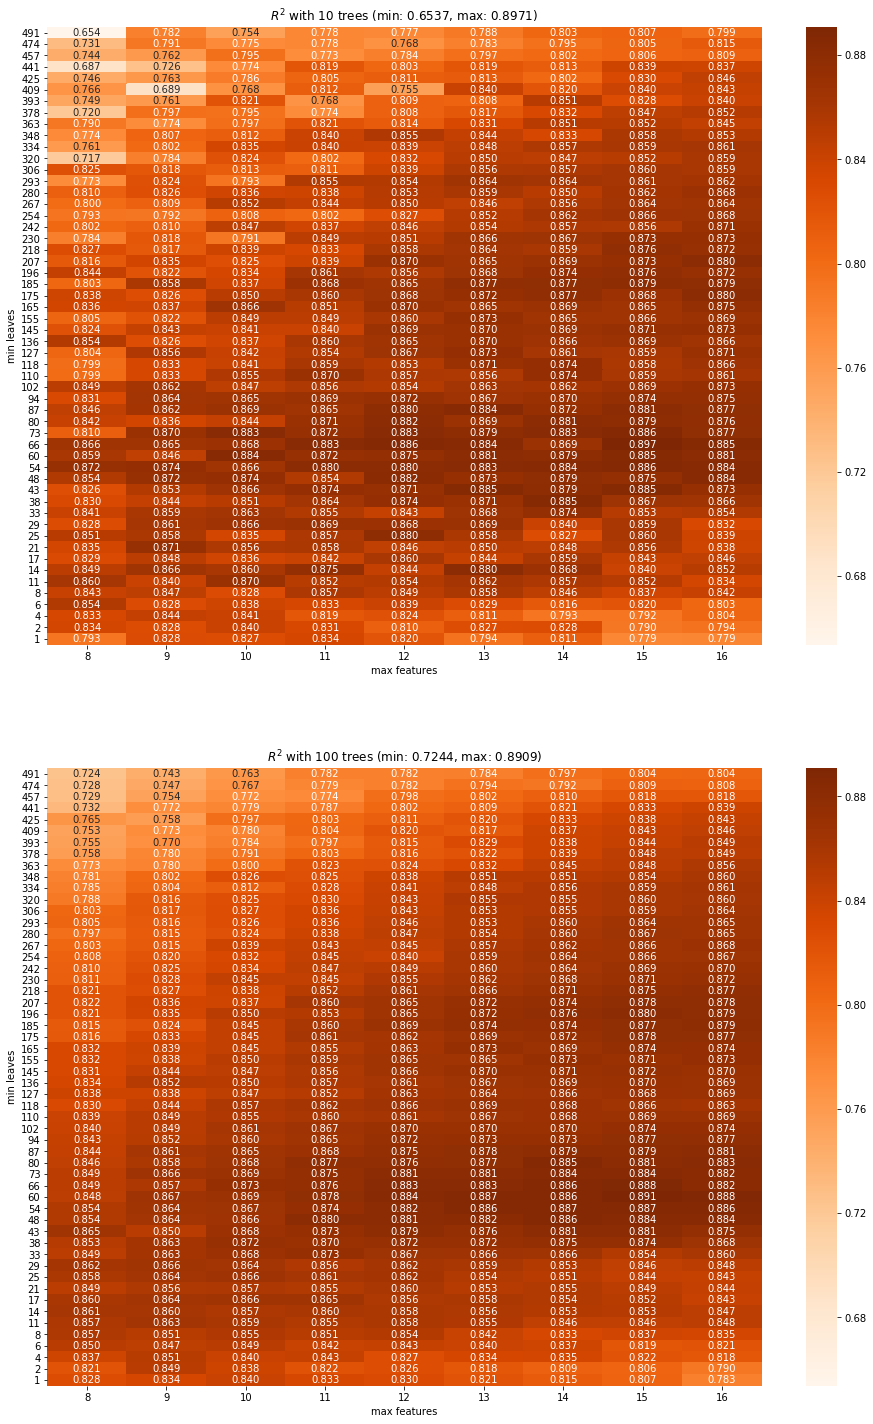

In [25]:
vmin = min(performance_low_nb_trees['R2'].min(), performance_high_nb_trees['R2'].min())
vmax = min(performance_low_nb_trees['R2'].max(), performance_high_nb_trees['R2'].max())

fig, (ax1, ax2) = plt.subplots(2, 1 , figsize=(16, 25));
plt.subplots_adjust(wspace=0.1);
sns.heatmap(df_r2_low_nb_trees.sort_index(ascending=False), annot=True, cmap="Oranges", linewidths=0, fmt='.3f', vmin=vmin, vmax=vmax, ax=ax1);
ax1.set_title(
    "$R^2$ with {0} trees (min: {1:.4f}, max: {2:.4f})".format(
        nb_trees,
        performance_low_nb_trees['R2'].min(),
        performance_low_nb_trees['R2'].max()
    )
);
sns.heatmap(df_r2_high_nb_trees.sort_index(ascending=False), annot=True, cmap="Oranges", linewidths=0, fmt='.3f', vmin=vmin, vmax=vmax, ax=ax2);
ax2.set_title(
    "$R^2$ with {0} trees (min: {1:.4f}, max: {2:.4f})".format(
        nb_trees_high,
        performance_high_nb_trees['R2'].min(),
        performance_high_nb_trees['R2'].max()
    )
);

# plt.savefig("R2-with-low-and-high-number-of-trees-heatmaps.png")

**Note.**  The color map is the same in the two heatmaps.  That is, it uses the same minimum and maximum values and therefore they can be compared.

In [26]:
sort_performance = performance_low_nb_trees.sort_values('R2')[['min leaves', 'max features', 'rmse', 'R2']].reset_index(drop=True)
sort_performance.head()

min_leaves, max_features, max_rmse, max_r2 = tuple(sort_performance.iloc[-1])
min_leaves = int(min_leaves)
max_features = int(max_features)

COL_WIDTH = 25
print("Outcomes with {0} trees:".format(nb_trees))
print("{0}: {1}".format("max features".ljust(COL_WIDTH), max_features))
print("{0}: {1}".format("min leaves".ljust(COL_WIDTH), min_leaves))
print("{0}: {1:.4f}".format("max RMSE".ljust(COL_WIDTH), max_rmse))
print("{0}: {1:.4f}".format("max R2".ljust(COL_WIDTH), max_r2))

Outcomes with 10 trees:
max features             : 15
min leaves               : 66
max RMSE                 : 6.2143
max R2                   : 0.8971


In [27]:
sort_performance = performance_high_nb_trees.sort_values('R2')[['min leaves', 'max features', 'rmse', 'R2']].reset_index(drop=True)
sort_performance.head()

min_leaves, max_features, max_rmse, max_r2 = tuple(sort_performance.iloc[-1])
min_leaves = int(min_leaves)
max_features = int(max_features)

COL_WIDTH = 25
print("Outcomes with {0} trees:".format(nb_trees_high))
print("{0}: {1}".format("max features".ljust(COL_WIDTH), max_features))
print("{0}: {1}".format("min leaves".ljust(COL_WIDTH), min_leaves))
print("{0}: {1:.4f}".format("max RMSE".ljust(COL_WIDTH), max_rmse))
print("{0}: {1:.4f}".format("max R2".ljust(COL_WIDTH), max_r2))

Outcomes with 100 trees:
max features             : 15
min leaves               : 60
max RMSE                 : 6.3990
max R2                   : 0.8909


### Observations and conclusions

By "performance" we understand a model's ability to achieve a low RMSE or equivalently a high $R^2$ (i.e. near 1).

1. The heatmap with higher number of trees exhibits a lot more regularity as can be expected.  Indeed, random forests produce their predictions by averaging over a number of trees, which ideally should be independent of one another.  For each pair of values of the parameters `max features` and `min leaves`, the variation of the output decreases with a large number of trees.  On the other hand, it is reasonable to think that the performance of random forests varies smoothly across the parameter space. This is of course not a rigorous statement but intuitively the regularity across the values for the parameters `max_features` and `min_samples_leaf`, for a large number of trees, should reflect the stabilizing effect of taking averages.  
1.  The better performance with a low number of trees is consistent with the higher variability of the results.  
1.  The metrics are not monotonic functions of the parameters.  In fact, there seems to be two distinct regions of near optima as depicted in the figure below.  From experience, the optimizer may be found in either one of them, although the region around `min_samples_leaf = 50` appears more stable.  Also, there does not seem to be any consistent and observable difference in the visualization of the forecast when consider one region or the other.  

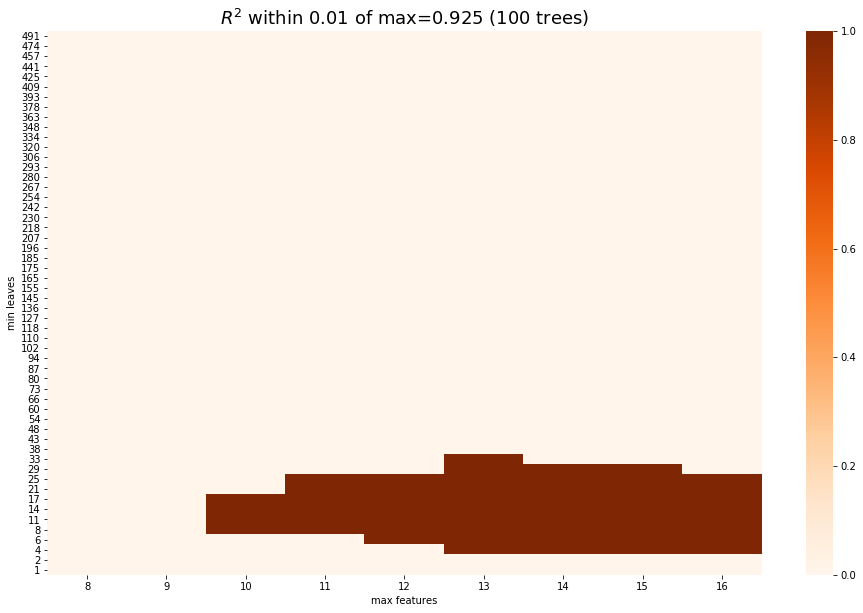

In [45]:
tol = 0.01

performance = performance_high_nb_trees.copy()

performance['near max'] = performance['R2'] > max_r2 - tol
performance['near max'] = performance['near max'].map({False: 0, True: 1})
performance_pivot = pd.pivot_table(performance, index='min leaves', columns='max features', values='near max')

fig, ax= plt.subplots(figsize=(16, 10));
sns.heatmap(performance_pivot.sort_index(ascending=False), cmap="Oranges", linewidths=0, fmt='.3f', ax=ax);
ax.set_title("$R^2$ within {0} of max={1:.3f} ({2} trees)".format(tol, max_r2, nb_trees_high), fontsize=18);
# plt.savefig("R2-within-0-005-of-max.png");

For definiteness we take the following values:

In [47]:
max_features, min_leaves = 15, 50

## Visualizing the predictions


In [52]:
m = RandomForestRegressor(n_jobs=-1, n_estimators=nb_trees_high, max_features=max_features, min_samples_leaf=min_leaves)
%time m.fit(X_train, y_train)
COL_WIDTH = 20
print("{0}: {1}".format("RMSE (train)".ljust(COL_WIDTH), rmse(m.predict(X_train), y_train)))
print("{0}: {1}".format("RMSE (validation)".ljust(COL_WIDTH), rmse(m.predict(X_valid), y_valid)))
print("{0}: {1}".format("R2 (train)".ljust(COL_WIDTH), m.score(X_train, y_train)))
print("{0}: {1}".format("R2 (validation)".ljust(COL_WIDTH), m.score(X_valid, y_valid)))

y_predict = m.predict(X_valid)

CPU times: user 995 ms, sys: 21.3 ms, total: 1.02 s
Wall time: 251 ms
RMSE (train)        : 4.5060678127808815
RMSE (validation)   : 6.560358194751935
R2 (train)          : 0.931579798696226
R2 (validation)     : 0.885311203538131


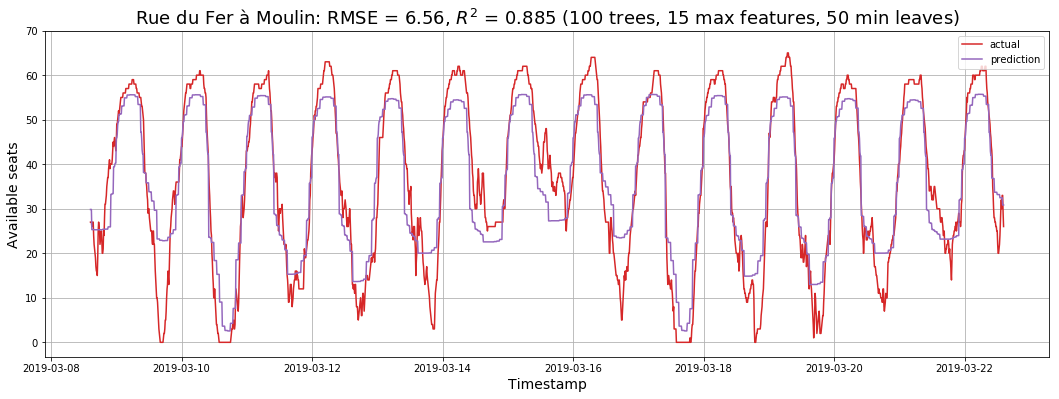

In [54]:
fig, ax = plt.subplots(figsize=(18, 6));
ax.plot(timestamps_valid['timestamp'], y_valid, COL_VALID);
ax.plot(timestamps_valid['timestamp'], y_predict, COL_PREDICT);
ax.set_title(
    "Rue du Fer à Moulin: RMSE = {0:.4g}, $R^2$ = {1:.3g} ({2} trees, {3} max features, {4} min leaves)".format(
        rmse(m.predict(X_valid), y_valid),
        m.score(X_valid, y_valid),
        nb_trees_high,
        max_features,
        min_leaves
    ),
    fontsize=18
);

ax.set_ylabel("Available seats", fontsize=14);
ax.set_yticks(range(0, 80, 10));
ax.set_xlabel("Timestamp", fontsize=14);
ax.legend(['actual', 'prediction'], loc='upper right')
ax.grid();
plt.savefig("moulin-random-forests.png");

There are any obvious differerences between the two sets of parameter values.  

## Rue d'Alésia

We now consider the data from the location at rue d'Alésia.  

We recall the constants:  

In [34]:
n_valid, n_trn, (MIN_LEAVES[0], MIN_LEAVES[-1]), (MAX_FEATURES[0], MAX_FEATURES[-1]), nb_trees_high

(2016, 8489, (1, 491), (8, 16), 100)

In [55]:
df, y, nas = proc_df(raw_data.drop('Moulin', axis=1), 'Alésia')
X_train, X_valid = split_vals(df, n_trn)
y_train, y_valid = split_vals(y, n_trn)

In [36]:
performance_list = []

for i, j in tqdm([(x, y) for x in MIN_LEAVES for y in MAX_FEATURES]):
    m = RandomForestRegressor(n_jobs=-1, n_estimators=nb_trees_high, min_samples_leaf=i, max_features=j)
    m.fit(X_train, y_train)
    D = {
        'min leaves': i,
        'max features': j,
        'rmse': rmse(m.predict(X_valid), y_valid),
        'R2': m.score(X_valid, y_valid)
    }
    performance_list.append(D)

100%|██████████| 486/486 [03:09<00:00,  2.72it/s]


In [37]:
performance_high_nb_trees = pd.DataFrame(performance_list)[['min leaves', 'max features', 'rmse', 'R2']]
df_rmse_high_nb_trees = pd.pivot_table(performance_high_nb_trees, index='min leaves', columns='max features', values='rmse')
df_r2_high_nb_trees = pd.pivot_table(performance_high_nb_trees, index='min leaves', columns='max features', values='R2')

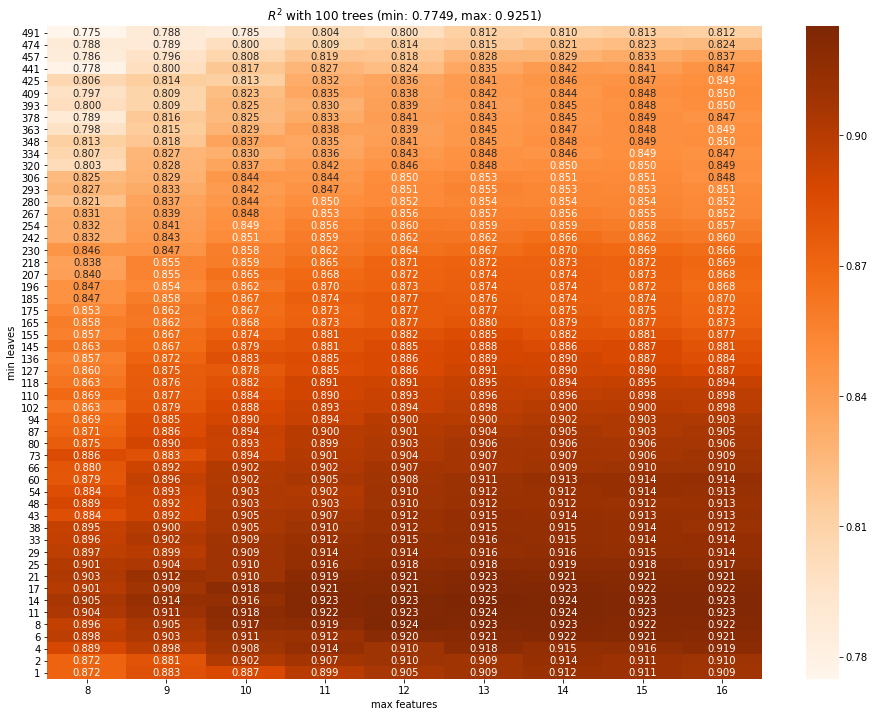

In [38]:
fig, ax = plt.subplots(figsize=(16, 12));

sns.heatmap(df_r2_high_nb_trees.sort_index(ascending=False), annot=True, cmap="Oranges", linewidths=0, fmt='.3f', ax=ax);
ax.set_title(
    "$R^2$ with {0} trees (min: {1:.4f}, max: {2:.4f})".format(
        nb_trees_high,
        performance_high_nb_trees['R2'].min(),
        performance_high_nb_trees['R2'].max()
    )
);

The pattern is quite different at rue d'Alésia: there seems to be a global maximum with a lower value of `min_samples_leaf`.  Note also that the color map does **not** use the same minimum and maximum values as for rue du Fer à Moulin.

In [39]:
sort_performance = performance_high_nb_trees.sort_values('R2')[['min leaves', 'max features', 'rmse', 'R2']].reset_index(drop=True)
sort_performance.head()

min_leaves, max_features, max_rmse, max_r2 = tuple(sort_performance.iloc[-1])
min_leaves = int(min_leaves)
max_features = int(max_features)

COL_WIDTH = 25
print("Outcomes with {0} trees:".format(nb_trees_high))
print("{0}: {1}".format("max features".ljust(COL_WIDTH), max_features))
print("{0}: {1}".format("min leaves".ljust(COL_WIDTH), min_leaves))
print("{0}: {1:.4f}".format("max RMSE".ljust(COL_WIDTH), max_rmse))
print("{0}: {1:.4f}".format("max R2".ljust(COL_WIDTH), max_r2))

Outcomes with 100 trees:
max features             : 13
min leaves               : 14
max RMSE                 : 6.8695
max R2                   : 0.9251


If one is to compare $R^2$ scores, the seat availability appears to be definitely more predictible at rue d'Alésia.  

Finally, let's visual the region around the optimizer:

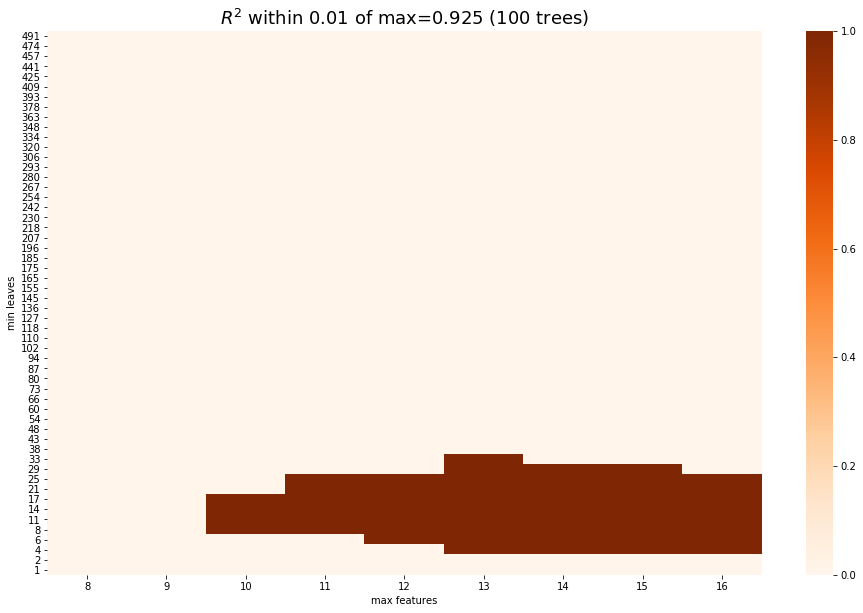

In [46]:
tol = 0.01

performance = performance_high_nb_trees.copy()

performance['near max'] = performance['R2'] > max_r2 - tol
performance['near max'] = performance['near max'].map({False: 0, True: 1})
performance_pivot = pd.pivot_table(performance, index='min leaves', columns='max features', values='near max')

fig, ax= plt.subplots(figsize=(16, 10));
sns.heatmap(performance_pivot.sort_index(ascending=False), cmap="Oranges", linewidths=0, fmt='.3f', ax=ax);
ax.set_title("$R^2$ within {0} of max={1:.3f} ({2} trees)".format(tol, max_r2, nb_trees_high), fontsize=18);
# plt.savefig("R2-within-0-005-of-max.png");

In [56]:
min_leaves = 14
max_features = 14

In [58]:
m = RandomForestRegressor(n_jobs=-1, n_estimators=nb_trees_high, max_features=max_features, min_samples_leaf=min_leaves)
%time m.fit(X_train, y_train)
COL_WIDTH = 20
print("{0}: {1}".format("RMSE (train)".ljust(COL_WIDTH), rmse(m.predict(X_train), y_train)))
print("{0}: {1}".format("RMSE (validation)".ljust(COL_WIDTH), rmse(m.predict(X_valid), y_valid)))
print("{0}: {1}".format("R2 (train)".ljust(COL_WIDTH), m.score(X_train, y_train)))
print("{0}: {1}".format("R2 (validation)".ljust(COL_WIDTH), m.score(X_valid, y_valid)))

y_predict = m.predict(X_valid)

CPU times: user 1.19 s, sys: 22.7 ms, total: 1.21 s
Wall time: 254 ms
RMSE (train)        : 3.7268784106854587
RMSE (validation)   : 6.962849550570947
R2 (train)          : 0.9735445630291402
R2 (validation)     : 0.9230395951379787


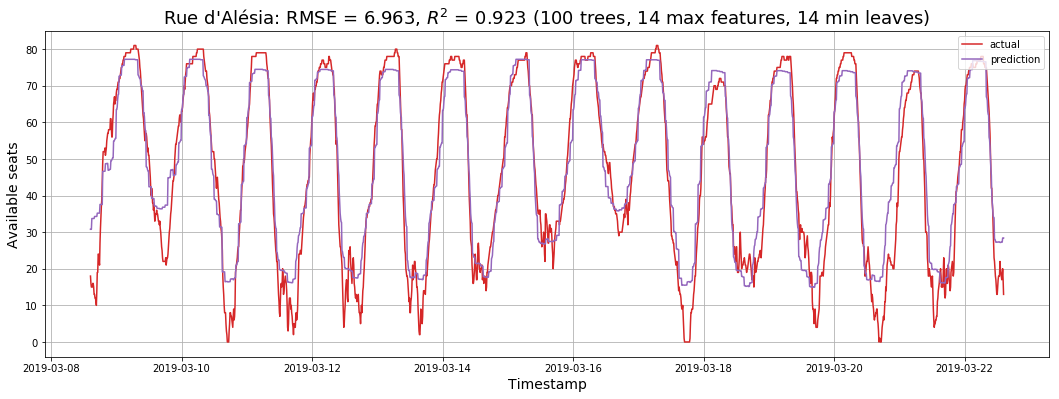

In [62]:
fig, ax = plt.subplots(figsize=(18, 6));
ax.plot(timestamps_valid['timestamp'], y_valid, COL_VALID);
ax.plot(timestamps_valid['timestamp'], y_predict, COL_PREDICT);
ax.set_title(
    "Rue d'Alésia: RMSE = {0:.4g}, $R^2$ = {1:.3g} ({2} trees, {3} max features, {4} min leaves)".format(
        rmse(m.predict(X_valid), y_valid),
        m.score(X_valid, y_valid),
        nb_trees_high,
        max_features,
        min_leaves
    ),
    fontsize=18
);

ax.set_ylabel("Available seats", fontsize=14);
ax.set_yticks(range(0, 90, 10));
ax.set_xlabel("Timestamp", fontsize=14);
ax.legend(['actual', 'prediction'], loc='upper right')
ax.grid();
# plt.savefig("alesia-random-forests.png");

## Further questions
The metrics RMSE $R^2$ measure the accuracy to which the random forests is able to predict the number of available seats.  It is however of more practical use to accurately estimate the number of available seats when there are few (at peak times) rather than in the middle of the night when there are many.  This means that weighted metrics should be used instead.  